In [ ]:
!pip install "tensorflow-text>=2.10"
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 17.0 MB/s 
     |████████████████████████████████| 588.3 MB 22 kB/s 
     |████████████████████████████████| 6.0 MB 54.4 MB/s 
     |████████████████████████████████| 1.7 MB 59.3 MB/s 
     |████████████████████████████████| 439 kB 76.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.

In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download the file
import pathlib

path_to_file_en = pathlib.Path('drive/MyDrive/en-pt_br/TED2020_en.txt')
path_to_file_en

PosixPath('drive/MyDrive/en-pt_br/TED2020_en.txt')

In [ ]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  #context = np.array([context for target, context, mess in pairs])
  text = np.array([target for target in pairs])

  return text

In [ ]:
target_raw_1 = load_data(path_to_file_en)
print(target_raw_1[100])

['A lot more to be said about that. ']


In [ ]:
path_to_file_sv = pathlib.Path('drive/MyDrive/en-pt_br/TED2020_pt_br.txt')
path_to_file_sv

PosixPath('drive/MyDrive/en-pt_br/TED2020_pt_br.txt')

In [ ]:
context_raw_1 = load_data(path_to_file_sv)
print(context_raw_1[100])

['Há muito mais a ser dito sobre isso. ']


In [ ]:
path_to_file = pathlib.Path('drive/MyDrive/en-pt_br/swe.txt')
path_to_file

PosixPath('drive/MyDrive/swe-eng/swe.txt')

In [ ]:
def load_data_total(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context, mess in pairs])
  target = np.array([target for target, context, mess in pairs])

  return context, target

In [ ]:
context_raw_2, target_raw_2 = load_data_total(path_to_file)

In [ ]:
context_raw_2 = context_raw_2.reshape((22187,1))
target_raw_2 = target_raw_2.reshape((22187,1))

In [ ]:
context_raw = np.concatenate((context_raw_1, context_raw_2))
target_raw = np.concatenate((target_raw_1, target_raw_2))

In [ ]:
context_raw_1.shape

(417623, 1)

In [ ]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [ ]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[[b'S\xc3\xa5 sm\xc3\xa5ningom kommer dessa att ta slut och ekonomins lagar kommer att driva civilisationen mot h\xc3\xa5llbar energi, oundvikligen. ']
 [b'Vi kontrollerar och identifierar butiker och restauranger som s\xc3\xa4ger att de \xc3\xa4r en zon fri fr\xc3\xa5n plastp\xc3\xa5sar och s\xc3\xa4tter det h\xc3\xa4r klisterm\xc3\xa4rket p\xc3\xa5 deras d\xc3\xb6rrar och publicerar deras namn p\xc3\xa5 sociala medier och i stora tidningar p\xc3\xa5 Bali. ']
 [b'Och den processen forts\xc3\xa4tter, och man b\xc3\xb6rjar genast att inse hur konstigt detta \xc3\xa4r. ']
 [b'Jag \xc3\xa4r nyfiken -- r\xc3\xa4ck upp h\xc3\xa4nderna -- vilka h\xc3\xa5ller med? ']
 [b'Det \xc3\xa4r luften som retirerar fr\xc3\xa5n ditt br\xc3\xb6st, d\xc3\xa5 den inte t\xc3\xb6rs husera i din lunga. ']], shape=(5, 1), dtype=string)

tf.Tensor(
[[b'Eventually you will run out, and the laws of economics will drive civilization towards sustainable energy, inevitably. ']
 [b'We check and recognize t

In [ ]:
example_text = tf.constant('Är du hemma?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc3\x84r du hemma?'
b'A\xcc\x88r du hemma?'


In [ ]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Är du hemma?
[START] ar du hemma ? [END]


In [ ]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [ ]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


['', '[UNK]', '[START]', '[END]', '.', ',', 'och', 'att', 'det', 'ar']

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', ',', '.', 'the', 'and', 'to', 'of']

In [ ]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 20, 1941, 42, 65, 7, 90, 319, 6, 1, 1326, 42, 7, 2510, 1, 134, 2400,
  461, 5, 4925, 4, 3]                                                    ,
 [2, 14, 2547, 6, 1, 1, 6, 1, 11, 123, 7, 18, 9, 12, 1, 1553, 41, 1, 6, 558,
  8, 15, 1, 16, 117, 3692, 6, 1, 117, 424, 16, 412, 1508, 6, 13, 191, 3191,
  16, 1, 4, 3]                                                              ,
 [2, 6, 22, 846, 590, 5, 6, 36, 209, 2296, 7, 1097, 38, 1348, 44, 9, 4, 3]]>

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] sa smaningom kommer dessa att ta slut och [UNK] lagar kommer att driva [UNK] mot hallbar energi , oundvikligen . [END]'

In [ ]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy())

[  2 108   3   0   0   0   0   0   0   0]

[  2 133   0   0   0   0   0   0   0   0]
[133   3   0   0   0   0   0   0   0   0]


In [ ]:
UNITS = 256

In [ ]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [ ]:

class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [ ]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 44)
Encoder output, shape (batch, s, units): (64, 44, 256)


In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 44, 256)
Target sequence, shape (batch, t, units): (64, 45, 256)
Attention result, shape (batch, t, units): (64, 45, 256)
Attention weights, shape (batch, t, s):    (64, 45, 44)


In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994],
      dtype=float32)

In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 44, 256)
input target tokens shape: (batch, t) (64, 45)
logits shape shape: (batch, target_vocabulary_size) (64, 45, 5000)


In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [ ]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'essential school plus reaction permission saudi protected letter defend voices',
       b'living exception universities union vacation immense resolve da voices crash',
       b'fixed fire curious social please wallet net previous wont first'],
      dtype=object)

In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 44)
Target tokens, shape: (batch, t) (64, 45)
logits, shape: (batch, t, target_vocabulary_size) (64, 45, 5000)


In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [ ]:
history = model.fit(
    train_ds.repeat(), 
    epochs=10,
    steps_per_epoch = 500,
    validation_data=val_ds,
    )

Epoch 1/10
500/500 [==============================] - 121s 196ms/step - loss: 4.4324 - masked_acc: 0.2795 - masked_loss: 4.4324 - val_loss: 3.5068 - val_masked_acc: 0.4014 - val_masked_loss: 3.5068
Epoch 2/10
500/500 [==============================] - 60s 120ms/step - loss: 3.0902 - masked_acc: 0.4634 - masked_loss: 3.0902 - val_loss: 2.7812 - val_masked_acc: 0.5069 - val_masked_loss: 2.7812
Epoch 3/10
500/500 [==============================] - 48s 95ms/step - loss: 2.6541 - masked_acc: 0.5233 - masked_loss: 2.6541 - val_loss: 2.5044 - val_masked_acc: 0.5442 - val_masked_loss: 2.5045
Epoch 4/10
500/500 [==============================] - 53s 106ms/step - loss: 2.3999 - masked_acc: 0.5568 - masked_loss: 2.4000 - val_loss: 2.4045 - val_masked_acc: 0.5586 - val_masked_loss: 2.4042
Epoch 5/10
500/500 [==============================] - 53s 106ms/step - loss: 2.2732 - masked_acc: 0.5725 - masked_loss: 2.2732 - val_loss: 2.3332 - val_masked_acc: 0.5663 - val_masked_loss: 2.3332
Epoch 6/10
500/

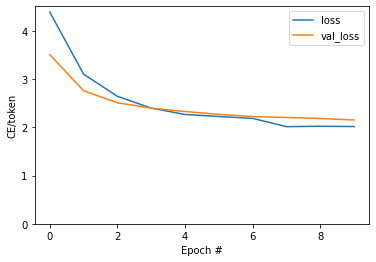

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()


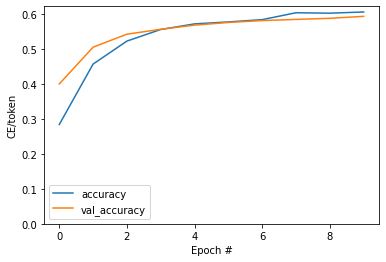

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [ ]:
result = model.translate(['Tre män i en bat (för att inte tala om hunden)']) # Tree men in a boat(not to talk about the dog)
result[0].numpy().decode()

'three men in a boat not to talk about the dog . '

In [ ]:
result = model.translate(['Det är söndag idag och vi gör vårt projekt tillsammans.']) # Tree men in a boat(not to talk about the dog)
result[0].numpy().decode()
                          

'its sunday today and we are doing our projects together . '

In [ ]:
result = model.translate(['Flera tusen ukrainska soldater har blivit dödade i kriget.']) # Tree men in a boat(not to talk about the dog)
result[0].numpy().decode()


'several thousand [UNK] soldiers have been killed in the war . '

In [ ]:
result = model.translate(['Tyskland är ute ur VM i fotboll för herrar.']) # Tree men in a boat(not to talk about the dog)
result[0].numpy().decode()       

'germany is outside of [UNK] in football , for gentlemen . '

CPU times: user 38.4 s, sys: 509 ms, total: 38.9 s
Wall time: 41.9 s
